In [297]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions

In [326]:
@model function alberts_model(n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w)
    
    x0 ~ NormalMeanPrecision(m_x_0, τ_x_0)
    
    τ_x ~ Gamma(a_x, b_x)
    
    w0 ~ NormalMeanPrecision(m_w_0, τ_w_0)
    
    τ_w ~ Gamma(a_w, b_w)
    
    x = randomvar(n)
    w = randomvar(n)
    y = datavar(Float64, n)
    
    x_nodes = Vector{FactorNode}(undef, n)
    w_nodes = Vector{FactorNode}(undef, n)
    
    x_i_min = x0
    w_i_min = w0
    
    for i in 1:n
        x_nodes[i], x[i] ~ NormalMeanPrecision(x_i_min, τ_x) where { portal = InitVaguePortal(), q = q(x[i], x_i_min)q(τ_x) }
        w_nodes[i], w[i] ~ NormalMeanPrecision(w_i_min, τ_w) where { portal = InitVaguePortal(), q = q(w[i], w_i_min)q(τ_w) }
        y[i] ~ NormalMeanPrecision(x[i] + w[i], 1.0)
        
        x_i_min = x[i]
        w_i_min = w[i]
    end
    
    return x, w, y, τ_x, τ_w, x_nodes, w_nodes
end

alberts_model (generic function with 2 methods)

In [327]:
n = 100

real_x = Vector{Float64}(undef, n)
real_w = Vector{Float64}(undef, n)
real_y = Vector{Float64}(undef, n)

real_x_τ = 0.1
real_w_τ = 0.1

x_i_min = 0.0
w_i_min = 1.0

for i in 1:n
    real_x[i] = rand(Normal(x_i_min, sqrt(1.0 / real_x_τ)))
    real_w[i] = rand(Normal(w_i_min, sqrt(1.0 / real_w_τ)))
    real_y[i] = rand(Normal(real_x[i] + real_w[i], 1.0))
    
    x_i_min = real_x[i]
    w_i_min = real_w[i]
end

In [328]:
m_x_0, τ_x_0 = 0.0, 100.0
m_w_0, τ_w_0 = 1.0, 100.0

a_x, b_x = 0.1, 1.0
a_w, b_w = 0.1, 1.0
;

In [329]:
import ProgressMeter

In [331]:
model, (x, w, y, τ_x, τ_w, x_nodes, w_nodes) = alberts_model(n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w);

for i in 1:n
    setmarginal!(x_nodes[i], :out_μ, vague(MvNormalMeanPrecision, 2))
    setmarginal!(w_nodes[i], :out_μ, vague(MvNormalMeanPrecision, 2))
end

xmarginals = Vector{Marginal}(undef, n)
wmarginals = Vector{Marginal}(undef, n)

x_τ_marginals = Vector{Marginal}()
w_τ_marginals = Vector{Marginal}()

xsub = subscribe!(collectLatest(getmarginals(x)), (mx) -> copyto!(xmarginals, mx))
wsub = subscribe!(collectLatest(getmarginals(w)), (mw) -> copyto!(wmarginals, mw))

xτsub = subscribe!(getmarginal(τ_x), (τ) -> push!(x_τ_marginals, τ))
wτsub = subscribe!(getmarginal(τ_w), (τ) -> push!(w_τ_marginals, τ))

ProgressMeter.@showprogress for i in 1:100
    update!(y, real_y)
end

unsubscribe!(xsub)
unsubscribe!(wsub)

unsubscribe!(xτsub)
unsubscribe!(wτsub)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [332]:
mean.(x_τ_marginals)[end], mean.(w_τ_marginals)[end]

(0.9406212776223412, 23.987496419397594)

In [333]:
using Plots

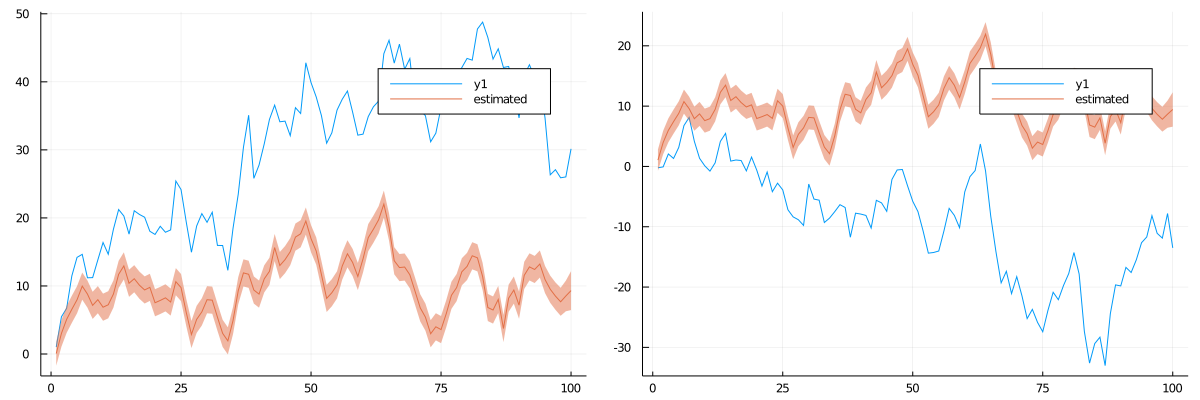

In [334]:
px1 = plot()
px2 = plot()

px1 = plot!(px1, real_x)
px1 = plot!(px1, mean.(xmarginals), ribbon = std.(xmarginals), label = :estimated)

px2 = plot!(px2, real_w)
px2 = plot!(px2, mean.(wmarginals), ribbon = std.(wmarginals), label = :estimated)

plot(px1, px2, size = (1200, 400))

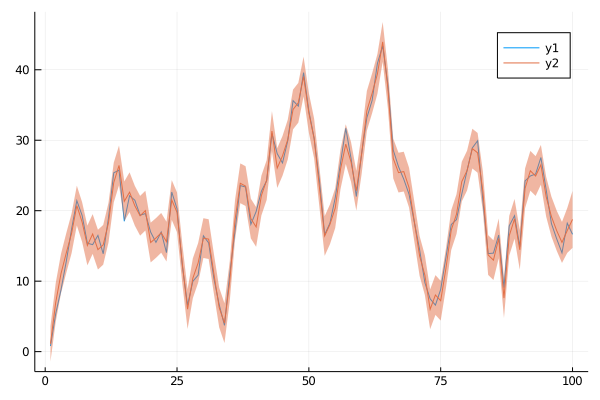

In [337]:
p = plot()

p = plot!(p, real_x .+ real_w)
p = plot!(p, mean.(xmarginals) + mean.(wmarginals), ribbon = (var.(xmarginals) + var.(wmarginals)) .|> sqrt)